In [ ]:
import os
from tqdm.autonotebook import tqdm, trange

import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split

C:\Users\zapas\AppData\Local\Temp\ipykernel_11628\3875975503.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [ ]:
pwd

'C:\\Users\\zapas\\Simpson CNN'

In [ ]:
import shutil
shutil.unpack_archive("journey-springfield.zip", "C:\\Users\\zapas\\Simpson CNN")


In [ ]:
cuda_is_available = torch.cuda.is_available()

if cuda_is_available:
  device = torch.device("cuda")
  print("cuda")
else:
  device = torch.device("cpu")
  print("cpu")

cpu


In [ ]:
# Преобразование обучающих данных для расширения обучающей выборки и её нормализация
# Для валидационной (тестовой) выборки только нормализация
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(244),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(244),
        transforms.ToTensor(),
    ]),
}

In [ ]:
test_dir = "C:\\Users\\zapas\\Simpson CNN\\testset"
train_dir = "C:\\Users\\zapas\\Simpson CNN\\train\\simpsons_dataset"

#тренировочный датасет
train_dataset = datasets.ImageFolder(train_dir, data_transforms['train'])

# получаем рандомные индексы, для разделения на train/val
train_indices, validation_indices = train_test_split(
    list(range(len(train_dataset))), train_size = 0.8)
# создаём train dataloader
# с помощью Subset(dataset, indices) делим на train/val
train_dataloader = {
        'train': torch.utils.data.DataLoader(
            dataset=torch.utils.data.Subset(train_dataset, train_indices),
            batch_size=24,
            shuffle=True,
            num_workers=2),
        'val': torch.utils.data.DataLoader(
            dataset=torch.utils.data.Subset(train_dataset, validation_indices),
            batch_size=24,
            shuffle=False,
            num_workers=2),
}



In [ ]:
#test датасет
test_dataset = datasets.ImageFolder(test_dir, data_transforms["test"])

test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=24,
    shuffle=False,
    num_workers=2)

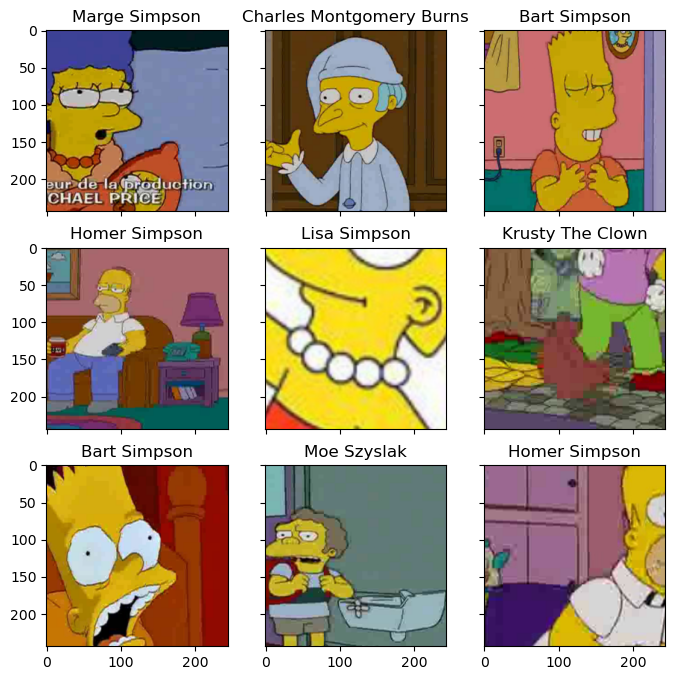

In [ ]:
# для отображения картинок ниже
dataset_sizes = {x: len(train_dataloader[x].dataset) for x in ['train', 'val']}
class_names = train_dataset.classes

inputs, classes = next(iter(train_dataloader['train']))
img = inputs[0]
type(img)
torch.Tensor
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)

for n in range(9):
    img = inputs[n]
    ax[n//3][n%3].imshow(img.permute(1, 2, 0))
    ax[n//3][n%3].set_title(' '.join(class_names[classes[n]].split('_')).title())

In [ ]:
from torchvision import models
n_classes = len(train_dataset.classes)

efficientnet_b2 = models.efficientnet_b2(weights=models.EfficientNet_B2_Weights.IMAGENET1K_V1, progress=True)

for param in efficientnet_b2.parameters():
    param.requires_grad = True

efficientnet_b2.classifier = nn.Sequential(
    nn.Linear(1408, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Linear(256, n_classes)
)

loss = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(efficientnet_b2.parameters(), lr=0.0003)

scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.3)

efficientnet_b2.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=16):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    losses = {'train': [], "val": []}
    accs = {'train': [], "val": []}

    pbar = trange(num_epochs, desc="Epoch:")

    for epoch in pbar:

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train(True)
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for data in tqdm(train_dataloader[phase], leave=False, desc=f"{phase} iter:"):
                inputs, labels = data

                if cuda_is_available:
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                else:
                    inputs, labels = inputs, labels

                if phase=="train":
                    optimizer.zero_grad()

                # forward pass
                if phase == "eval":
                    with torch.no_grad():
                        outputs = model(inputs)
                else:
                    outputs = model(inputs)
                preds = torch.argmax(outputs, -1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # статистика
                running_loss += loss.item()
                running_corrects += int(torch.sum(preds == labels.data))


            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            losses[phase].append(epoch_loss)
            accs[phase].append(epoch_acc)

            pbar.set_description('{} Loss: {:.4f} Acc: {:.4f}'.format(
                                    phase, epoch_loss, epoch_acc
                                ))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
            scheduler.step()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, accs, losses

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for data in test_loader:
            inputs, labels = data
            if cuda_is_available:
                inputs = inputs.cuda()
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
model, accs, losses = train_model(efficientnet_b2, loss, optimizer, scheduler, num_epochs = 10)

Epoch::   0%|          | 0/10 [00:00<?, ?it/s]

train iter::   0%|          | 0/698 [00:00<?, ?it/s]

val iter::   0%|          | 0/175 [00:00<?, ?it/s]

train iter::   0%|          | 0/698 [00:00<?, ?it/s]

val iter::   0%|          | 0/175 [00:00<?, ?it/s]

train iter::   0%|          | 0/698 [00:00<?, ?it/s]

val iter::   0%|          | 0/175 [00:00<?, ?it/s]

train iter::   0%|          | 0/698 [00:00<?, ?it/s]

val iter::   0%|          | 0/175 [00:00<?, ?it/s]

train iter::   0%|          | 0/698 [00:00<?, ?it/s]

val iter::   0%|          | 0/175 [00:00<?, ?it/s]

train iter::   0%|          | 0/698 [00:00<?, ?it/s]

val iter::   0%|          | 0/175 [00:00<?, ?it/s]

train iter::   0%|          | 0/698 [00:00<?, ?it/s]

val iter::   0%|          | 0/175 [00:00<?, ?it/s]

train iter::   0%|          | 0/698 [00:00<?, ?it/s]

val iter::   0%|          | 0/175 [00:00<?, ?it/s]

train iter::   0%|          | 0/698 [00:00<?, ?it/s]

val iter::   0%|          | 0/175 [00:00<?, ?it/s]

train iter::   0%|          | 0/698 [00:00<?, ?it/s]

val iter::   0%|          | 0/175 [00:00<?, ?it/s]

Training complete in 640m 56s
Best val Acc: 0.923812


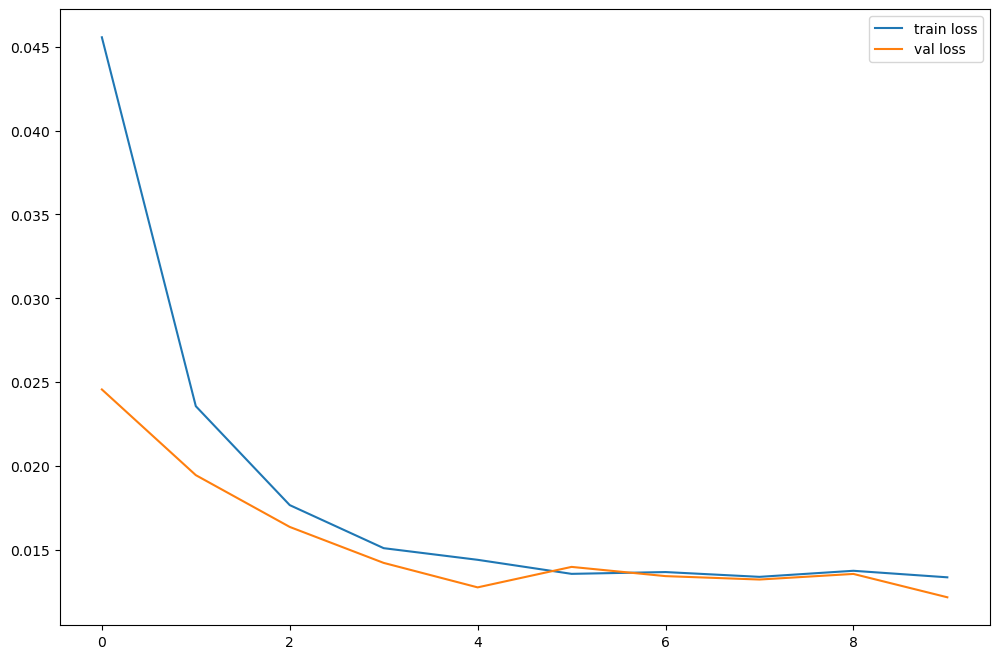

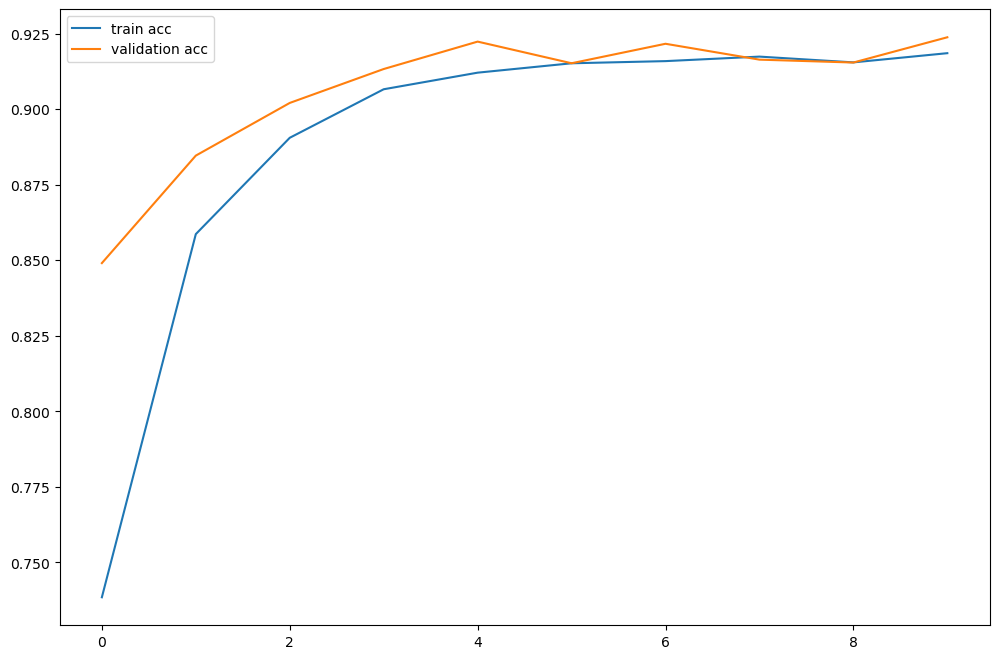

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(losses['train'], label="train loss")
plt.plot(losses['val'], label="val loss")
plt.legend()
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(accs["train"], label="train acc")
plt.plot(accs["val"], label="validation acc")
plt.legend()
plt.show()

In [ ]:
probs = predict(model, test_dataloader)

In [ ]:
import os
import pandas as pd

test_dataset = datasets.ImageFolder(test_dir, data_transforms['test'])
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=24, shuffle=False, num_workers=2)


test_files = os.listdir("C:\\Users\\zapas\\Simpson CNN\\testset\\testset")

file_names = [os.path.splitext(file)[0] + '.jpg' for file in test_files]

predicted_classes = [class_names[p.argmax()] for p in probs]




In [ ]:
len(predicted_classes), len(file_names)

(991, 991)

In [ ]:
predicted_classes

['nelson_muntz',
 'bart_simpson',
 'ned_flanders',
 'chief_wiggum',
 'apu_nahasapeemapetilon',
 'kent_brockman',
 'edna_krabappel',
 'chief_wiggum',
 'lisa_simpson',
 'kent_brockman',
 'lenny_leonard',
 'marge_simpson',
 'kent_brockman',
 'ned_flanders',
 'moe_szyslak',
 'comic_book_guy',
 'abraham_grampa_simpson',
 'edna_krabappel',
 'kent_brockman',
 'lisa_simpson',
 'marge_simpson',
 'nelson_muntz',
 'comic_book_guy',
 'mayor_quimby',
 'homer_simpson',
 'apu_nahasapeemapetilon',
 'krusty_the_clown',
 'krusty_the_clown',
 'ned_flanders',
 'edna_krabappel',
 'apu_nahasapeemapetilon',
 'chief_wiggum',
 'apu_nahasapeemapetilon',
 'ned_flanders',
 'marge_simpson',
 'abraham_grampa_simpson',
 'homer_simpson',
 'sideshow_bob',
 'lisa_simpson',
 'charles_montgomery_burns',
 'chief_wiggum',
 'kent_brockman',
 'abraham_grampa_simpson',
 'milhouse_van_houten',
 'lenny_leonard',
 'kent_brockman',
 'nelson_muntz',
 'comic_book_guy',
 'chief_wiggum',
 'nelson_muntz',
 'mayor_quimby',
 'charles_mo

In [ ]:
submit_df = pd.DataFrame({'Id': file_names, 'Expected': predicted_classes})
submit_file_path = "submit.csv"
submit_df.to_csv(submit_file_path, index=False)